# Loading Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing all 3 datasets of all 3 sectors

### Managing seasonal and cyclic effects

In [3]:
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)  # Assuming monthly data
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

### Finance Sector

In [4]:
finance_df = pd.read_csv("./Dataset/Monthly.csv")
finance_df['Date'] = pd.to_datetime(finance_df['Date'])
finance_df.drop_duplicates(inplace=True)
finance_df.fillna(method='ffill', inplace=True)
finance_df['close'] = manage_seasonal_cyclic(finance_df['close'])


### Energy Sector

In [5]:
energy_df = pd.read_csv("./Dataset/Hourly.csv")
energy_df['Datetime'] = pd.to_datetime(energy_df['Datetime'])
energy_df.drop_duplicates(inplace=True)
energy_df.fillna(method='ffill', inplace=True)
energy_df['AEP_MW'] = manage_seasonal_cyclic(energy_df['AEP_MW'])

### Environmental Sector

In [6]:
environment_df = pd.read_csv("./Dataset/Daily.csv")
environment_df['date'] = pd.to_datetime(environment_df['date'])
environment_df.drop_duplicates(inplace=True)
environment_df.fillna(method='ffill', inplace=True)
environment_df['value'] = manage_seasonal_cyclic(environment_df['value'])

In [ ]:
# Visualizing Finance sector
plt.figure(figsize=(14, 6))
plt.plot(finance_df['Date'], manage_seasonal_cyclic(finance_df['close']))
plt.title('Finance Sector Monthly Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# Visualizing Energy sector
plt.figure(figsize=(14, 6))
plt.plot(energy_df['Datetime'], manage_seasonal_cyclic(energy_df['AEP_MW']))
plt.title('Energy Sector Hourly Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.show()

# Visualizing Environmental sector
plt.figure(figsize=(14, 6))
plt.plot(environment_df['date'], manage_seasonal_cyclic(environment_df['value']))
plt.title('Environmental Sector Daily CO2 Concentrations')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()


In [ ]:
finance_df, energy_df, environment_df

# Model Development

### Arima

In [10]:
# Function to check the stationarity of the data
def check_stationarity(data):
    result = adfuller(data)
    if result[1] <= 0.05:
        return True, result[0]
    else:
        return False, result[0]

# Function to difference the data and determine the order of differencing (d)
def difference_data(data):
    d = 0
    stationary = False
    while not stationary:
        stationary, adf_statistic = check_stationarity(data)
        if not stationary:
            d += 1
            data = data.diff().dropna()  # Difference the data
    return data, d

# Stationarize finance sector data
finance_stationary, d_finance = difference_data(finance_df['close'])
print("Differencing order for finance sector data:", d_finance)

# Stationarize environmental sector data
environment_stationary, d_environment = difference_data(environment_df['value'])
print("Differencing order for environmental sector data:", d_environment)

Differencing order for finance sector data: 1
Differencing order for environmental sector data: 1


In [9]:
# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]  # Use iloc for integer-based indexing
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        try:
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test.iloc[t])  # Append test data
        except Exception as e:
            print(f'Error occurred: {e}')
            continue
    error = mean_squared_error(test, predictions)
    return error

# Function to find the best ARIMA model parameters
def find_best_arima_parameters(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score}')
    return best_cfg


p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)


best_cfg_finance = find_best_arima_parameters(finance_stationary, p_values, d_values, q_values)
print(best_cfg_finance)
best_cfg_energy = find_best_arima_parameters(energy_df['AEP_MW'], p_values, d_values, q_values)
print(best_cfg_energy)
best_cfg_environment = find_best_arima_parameters(environment_stationary, p_values, d_values, q_values)
print(best_cfg_environment)


ARIMA(0, 0, 0) MSE=2142.256568654966
ARIMA(0, 0, 1) MSE=2123.410481944836
ARIMA(0, 0, 2) MSE=2133.595430523964
ARIMA(0, 1, 0) MSE=4789.713741660984
ARIMA(0, 1, 1) MSE=2143.1532608591287
ARIMA(0, 1, 2) MSE=2129.263658154238
ARIMA(0, 2, 0) MSE=15194.351410627896


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 2, 1) MSE=4791.129637606791


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA(0, 2, 2) MSE=2169.610222666065
ARIMA(1, 0, 0) MSE=2122.389145684487
ARIMA(1, 0, 1) MSE=2131.5210056011783


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 2) MSE=2132.8209629852477
ARIMA(1, 1, 0) MSE=3162.490408239525
ARIMA(1, 1, 1) MSE=2123.3929035808524


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) MSE=72870.573722104
ARIMA(1, 2, 0) MSE=7230.627666426725
ARIMA(1, 2, 1) MSE=3163.163128400278


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

ARIMA(1, 2, 2) MSE=5600410.439200389
ARIMA(2, 0, 0) MSE=2132.6512675093823


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) MSE=2135.8163733753336


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA(2, 0, 2) MSE=2158.462245522095
ARIMA(2, 1, 0) MSE=2855.0673429208096
ARIMA(2, 1, 1) MSE=2133.7655071611


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) MSE=2119.1747206614104
ARIMA(2, 2, 0) MSE=5287.64028153091
ARIMA(2, 2, 1) MSE=2855.6149070507486


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.
Error occurred: LU decomposition error.


In [ ]:
# print(best_cfg_finance)
# print(best_cfg_energy)

### ANN

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_and_evaluate_ann(X_train, y_train, X_test, y_test):
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build the ANN model
    ann_model = build_ann_model(X_train_scaled.shape[1])
    
    # Train the model
    history = ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    loss, metric = ann_model.evaluate(X_test_scaled, y_test)
    
    return loss, metric

# For finance dataset
X_finance = finance_df.drop(columns=['Date', 'close'])
y_finance = finance_df['close']
X_train_finance, X_test_finance, y_train_finance, y_test_finance = train_test_split(X_finance, y_finance, test_size=0.2, random_state=42)

finance_loss, finance_metric = train_and_evaluate_ann(X_train_finance, y_train_finance, X_test_finance, y_test_finance)
print(f'Finance Dataset - Loss: {finance_loss}, Metric: {finance_metric}')

# For energy dataset
X_energy = energy_df.drop(columns=['Datetime'])
y_energy = energy_df['AEP_MW']
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(X_energy, y_energy, test_size=0.2, random_state=42)

energy_loss, energy_metric = train_and_evaluate_ann(X_train_energy, y_train_energy, X_test_energy, y_test_energy)
print(f'Energy Dataset - Loss: {energy_loss}, Metric: {energy_metric}')

# For environment dataset
X_environment = environment_df.drop(columns=['date'])
y_environment = environment_df['value']
X_train_environment, X_test_environment, y_train_environment, y_test_environment = train_test_split(X_environment, y_environment, test_size=0.2, random_state=42)

environment_loss, environment_metric = train_and_evaluate_ann(X_train_environment, y_train_environment, X_test_environment, y_test_environment)
print(f'Environment Dataset - Loss: {environment_loss}, Metric: {environment_metric}')



c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


37/37 [==============================] - 0s 1ms/step - loss: 294.3667 - mae: 10.3720
Finance Dataset - Loss: 294.36669921875, Metric: 10.37204360961914


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


758/758 [==============================] - 1s 748us/step - loss: 0.0849 - mae: 0.0163
Energy Dataset - Loss: 0.0848766565322876, Metric: 0.016282927244901657


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


118/118 [==============================] - 0s 790us/step - loss: 6.0989e-04 - mae: 0.0209
Environment Dataset - Loss: 0.0006098928861320019, Metric: 0.020916249603033066


### SRIMA

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_data(data):
    d = 0
    stationary = False
    while not stationary:
        stationary, adf_statistic = check_stationarity(data)
        if not stationary:
            d += 1
            data = data.diff().dropna()  # Difference the data
    return data, d

# Function to difference the seasonal data and determine the order of seasonal differencing (D)
def difference_seasonal_data(data, m):
    D = 0
    seasonal_stationary = False
    while not seasonal_stationary:
        seasonal_stationary, _ = check_stationarity(data)
        if not seasonal_stationary:
            D += 1
            data = data.diff(m).dropna()  # Difference the data with a seasonal lag of m
    return data, D


Differencing order for finance sector data: 1


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


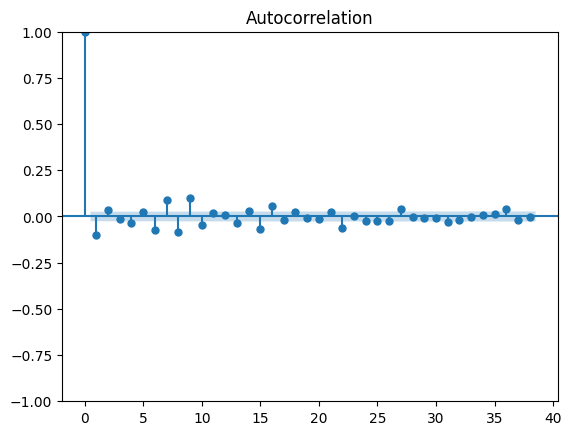

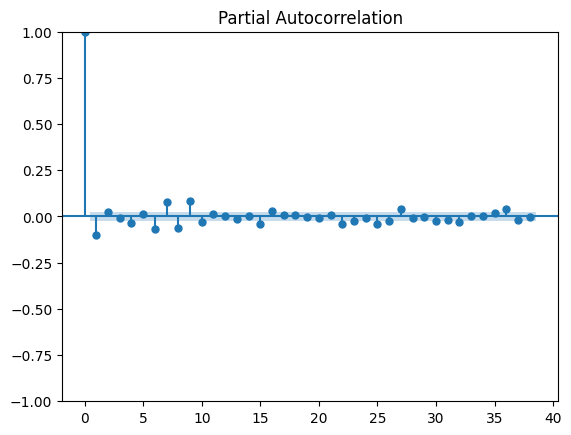

Differencing order for environmental sector data: 1


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


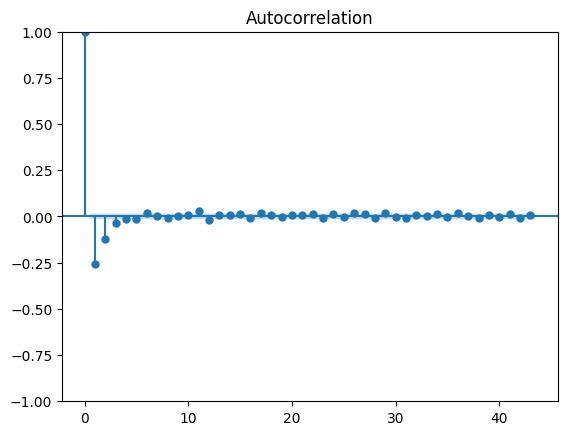

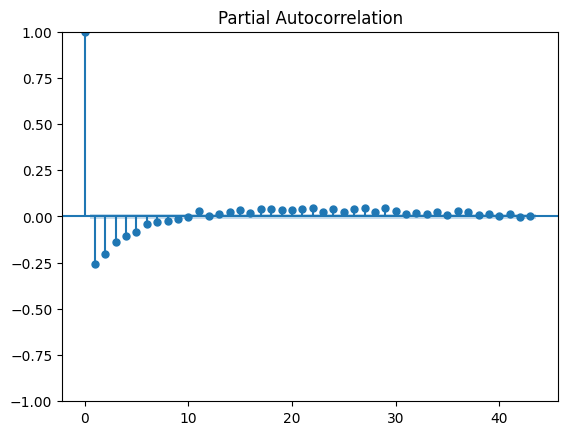

Differencing order for energy sector data: 0


c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


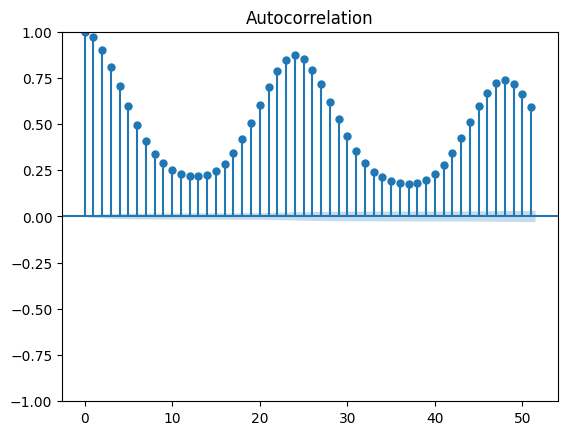

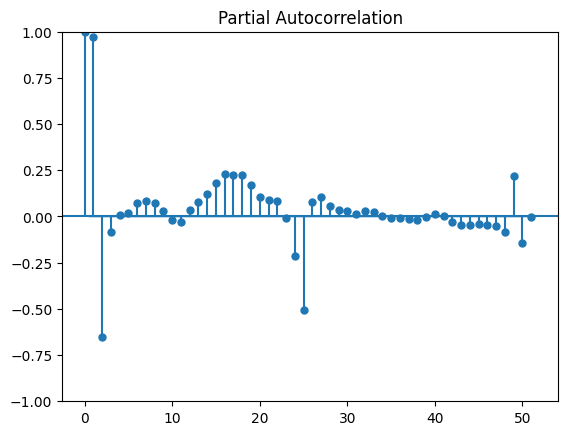

In [11]:
# Determine the order of differencing (d) for finance sector data
finance_diff, d_finance = difference_data(finance_df['close'])
print("Differencing order for finance sector data:", d_finance)

# Determine the order of seasonal differencing (D) for finance sector data
plot_acf(finance_diff)
plot_pacf(finance_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters

# Determine the order of differencing (d) for environmental sector data
environment_diff, d_environment = difference_data(environment_df['value'])
print("Differencing order for environmental sector data:", d_environment)

# Determine the order of seasonal differencing (D) for environmental sector data
plot_acf(environment_diff)
plot_pacf(environment_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters

# Determine the order of differencing (d) for energy sector data
energy_diff, d_energy = difference_data(energy_df['AEP_MW'])
print("Differencing order for energy sector data:", d_energy)

# Determine the order of seasonal differencing (D) for energy sector data
plot_acf(energy_diff)
plot_pacf(energy_diff)
plt.show()  # Visualize ACF and PACF plots to estimate seasonal parameters
